In [25]:
# IMPORT LIBRARIES
# Core libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model selection & tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

# Metrics
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, RocCurveDisplay, roc_auc_score, make_scorer
)

# Calibration
from sklearn.calibration import calibration_curve

***The Question:*** Based on a patient's clinical and demographic data, can we predict if they have heart disease?

**Kaggle Link to Dataset:** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

# **Variable Information**

***Age:***

age of the patient [years]

***Sex:***

sex of the patient [M: Male, F: Female]

***ChestPainType:***

chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

***RestingBP:***

resting blood pressure [mm Hg]

***Cholesterol:***

serum cholesterol [mm/dl]

***FastingBS:***

fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

***RestingECG:***

resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

***MaxHR:***

maximum heart rate achieved [Numeric value between 60 and 202]

***ExerciseAngina:***

exercise-induced angina [Y: Yes, N: No] ; this refers to whether or not they have chest pain during exercise

***Oldpeak:***

oldpeak = ST [Numeric value measured in depression]

***ST_Slope:***

the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

***HeartDisease:***

output class [1: heart disease, 0: Normal] ; this is the response variable

# **Data Exploration & Initial Cleaning**

In [2]:
# MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Define file path
file_path = "/content/drive/MyDrive/heart_disease_prediction.csv"

# Load the data as a df
heart_df = pd.read_csv(file_path)

# Take a look at the df
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [11]:
# Take a look at summary stats for the numerical variables
heart_df.describe().round(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [12]:
# See if there are any missing values
heart_df.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [13]:
# Confirm there are no duplicates
print(heart_df.duplicated().sum())

0


In [14]:
# Show info for non numerical variables
# Select only categorical columns
categorical_cols = heart_df.select_dtypes(include=['object', 'category']).columns

# Build summary table
cat_summary_list = []
for col in categorical_cols:
    counts = heart_df[col].value_counts(normalize=True).mul(100).round(1)
    for category, pct in counts.items():
        cat_summary_list.append([col, category, f"{pct}%"])

# Create DataFrame
cat_summary_df = pd.DataFrame(cat_summary_list, columns=["Variable", "Category", "Percentage"])

# Display
print(cat_summary_df.to_string(index=False))

      Variable Category Percentage
           Sex        M      79.0%
           Sex        F      21.0%
 ChestPainType      ASY      54.0%
 ChestPainType      NAP      22.1%
 ChestPainType      ATA      18.8%
 ChestPainType       TA       5.0%
    RestingECG   Normal      60.1%
    RestingECG      LVH      20.5%
    RestingECG       ST      19.4%
ExerciseAngina        N      59.6%
ExerciseAngina        Y      40.4%
      ST_Slope     Flat      50.1%
      ST_Slope       Up      43.0%
      ST_Slope     Down       6.9%


In [15]:
# Take a look at the df's info now to observe data types and confirm changes
# thus far
print('\n' + '-'*18 + ' Dataframe Info ' + '-'*18)
print(heart_df.info())

print('\n' + '-'*10 + ' Dimnensions (rows, columns) ' + '-'*10)
print(heart_df.shape)


------------------ Dataframe Info ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

---------- Dimnensions (rows, columns) ----------
(918, 12)


# **Feature Engineering**

In [16]:
def add_engineered_features(df):
    df = df.copy()

    # Transform skewed variables
    df['Cholesterol_log'] = np.log1p(df['Cholesterol'])
    df['Oldpeak_log'] = np.log1p(df['Oldpeak'] + abs(df['Oldpeak'].min()) + 1)  # handle negatives if any

    # Interaction terms
    df['Age_Cholesterol'] = df['Age'] * df['Cholesterol']
    df['Age_MaxHR'] = df['Age'] * df['MaxHR']
    df['BP_Cholesterol'] = df['RestingBP'] * df['Cholesterol']

    # Polynomial terms
    # df['Age_sq'] = df['Age'] ** 2
    # df['Oldpeak_sq'] = df['Oldpeak'] ** 2

    # Ratios
    # df['Chol_MaxHR_ratio'] = df['Cholesterol'] / (df['MaxHR'] + 1e-5)
    # df['BP_Age_ratio'] = df['RestingBP'] / (df['Age'] + 1e-5)

    # Clinical flags
    df['HighCholFlag'] = (df['Cholesterol'] > 240).astype(int)
    df['HighBPFlag'] = (df['RestingBP'] >= 140).astype(int)

    return df

In [17]:
# Feature engineering function calibrated for random forest and boosting
def add_engineered_features_rf(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Clinical flags
    if 'Cholesterol' in df.columns:
        df['HighCholFlag'] = (df['Cholesterol'] >= 240).astype(int)
        df['Chol_cat'] = pd.cut(
            df['Cholesterol'],
            bins=[-np.inf, 200, 239, np.inf],
            labels=['<200', '200-239', '>=240']
        ).astype('object')  # <-- important for your pipeline

    if 'RestingBP' in df.columns:
        df['HighBPFlag'] = (df['RestingBP'] >= 140).astype(int)
        df['BP_cat'] = pd.cut(
            df['RestingBP'],
            bins=[-np.inf, 120, 139, np.inf],
            labels=['<120', '120-139', '>=140']
        ).astype('object')

    if 'Oldpeak' in df.columns:
        df['ST_depression_high'] = (df['Oldpeak'] >= 2.0).astype(int)

    if 'Age' in df.columns:
        df['Age_bin'] = pd.cut(
            df['Age'],
            bins=[-np.inf, 39, 49, 59, 69, np.inf],
            labels=['<40', '40-49', '50-59', '60-69', '70+']
        ).astype('object')

    if 'MaxHR' in df.columns:
        df['MaxHR_bin'] = pd.cut(
            df['MaxHR'],
            bins=[-np.inf, 100, 140, np.inf],
            labels=['low', 'mid', 'high']
        ).astype('object')

    # Simple missing flags (numeric so they go through your numerical imputer)
    for col in ['Cholesterol', 'RestingBP', 'Oldpeak', 'MaxHR', 'Age']:
        if col in df.columns:
            df[f'{col}_missing'] = df[col].isna().astype(int)

    return df


# **Feature Preprocessing**

In [18]:
# FOR FEATURE ENGINEERING | currently using RF optimized function
eng_heart_df = add_engineered_features_rf(heart_df)

# Take a look at the new features that engineering added
eng_heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,HighBPFlag,BP_cat,ST_depression_high,Age_bin,MaxHR_bin,Cholesterol_missing,RestingBP_missing,Oldpeak_missing,MaxHR_missing,Age_missing
0,40,M,ATA,140,289,0,Normal,172,N,0.0,...,1,>=140,0,40-49,high,0,0,0,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,...,1,>=140,0,40-49,high,0,0,0,0,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,...,0,120-139,0,<40,low,0,0,0,0,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,...,0,120-139,0,40-49,mid,0,0,0,0,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,...,1,>=140,0,50-59,mid,0,0,0,0,0


In [19]:
# USING THE ENGINEERED FEATURES
# Define the target (reponse) variable and seperate it from the predictors
X = eng_heart_df.drop(columns=['HeartDisease'])
y = eng_heart_df['HeartDisease'] # what we're predicting

# Identify the column data types and group them as appropriately
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical columns
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the preprocessors to form overall preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)])

# **Train/ Test Split**

In [20]:
# Create a train/ test split of the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1)

# **Random Forest Classifier (Baseline & Hyperparameter Tuning)**


------------------ Confusion Matrix (Random Forest) ------------------
[[ 66   8]
 [  8 102]]

------------------ Scores (Random Forest) ------------------
Accuracy: 0.91
Precision: 0.93
Recall: 0.93


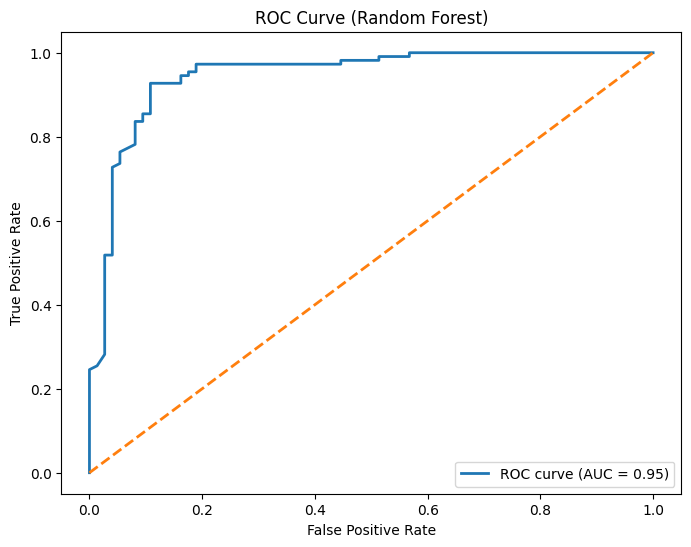

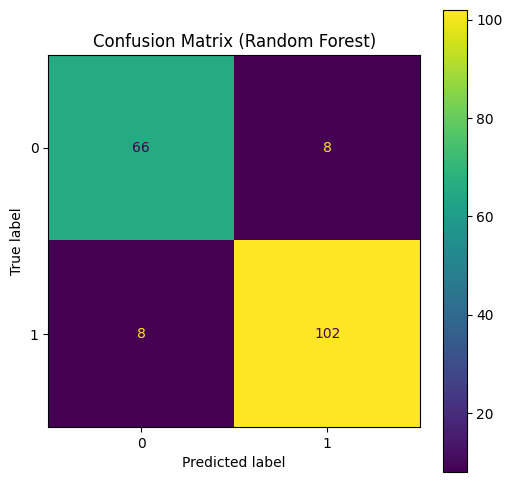

In [22]:
# --- BASELINE RANDOM FOREST ---------------------------------------------------
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestClassifier(
                                  n_estimators=400,
                                  max_features='sqrt',
                                  n_jobs=-1,
                                  random_state=42
                              ))])

# Fit baseline model
rf_pipeline.fit(X_train, y_train)

# Predictions
rf_pred = rf_pipeline.predict(X_test)

# Confusion matrix
print('\n' + '-'*18 + ' Confusion Matrix (Random Forest) ' + '-'*18)
rf_cm = confusion_matrix(y_test, rf_pred)
print(rf_cm)

# Scores
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
print('\n' + '-'*18 + ' Scores (Random Forest) ' + '-'*18)
print("Accuracy:", round(rf_accuracy, 2))
print("Precision:", round(rf_precision, 2))
print("Recall:", round(rf_recall, 2))

# ROC curve for baseline
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = roc_auc_score(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_pipeline.classes_).plot(ax=ax)
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# **Bagging**

In [23]:
### BAGGING ### ----------------------------------------------------------------

# 4) Takes average of multiple decision trees to keep from overfitting
base_tree = DecisionTreeClassifier(random_state=1, max_depth=12, min_samples_leaf=5)
try:
    bag = BaggingRegressor(estimator=base_tree, n_estimators=100, random_state=1)
except TypeError:
    bag = BaggingRegressor(base_estimator=base_tree, n_estimators=100, random_state=1)

# 5) Turn text to numeric values and train Bagging model
bagging_pipe = Pipeline([("prep", preprocessor), ("bag", bag)])

# Fit the model
bagging_pipe.fit(X_train, y_train)
bagging_preds = bagging_pipe.predict(X_test)

# Score Metrics
mae = mean_absolute_error(y_test, bagging_preds)
rmse = np.sqrt(mean_squared_error(y_test, bagging_preds))  # manual RMSE
r2 = r2_score(y_test, bagging_preds)

print("MAE :", round(mae, 2), "days")
print("RMSE:", round(rmse, 2), "days")
print("R^2 :", round(r2, 3))

MAE : 0.18 days
RMSE: 0.31 days
R^2 : 0.609


# **XGBoost**

In [27]:
# Build and Train the XGBoost Model
print("Shape:", heart_df.shape)
print("Columns:", heart_df.columns.tolist())
display(heart_df.head())

# ==== Pick target column (auto-detect common names) ====
possible_targets = ['HeartDisease', 'target', 'Outcome', 'heart_disease', 'label']
TARGET = None
for t in possible_targets:
    if t in heart_df.columns:
        TARGET = t
        break
if TARGET is None:
    raise ValueError(
        "Couldn't find the target column. "
        f"Tried {possible_targets}. Available columns: {heart_df.columns.tolist()}"
    )
print("Using target column:", TARGET)

# ==== Split features/label ====
X = heart_df.drop(columns=[TARGET])
y = heart_df[TARGET]

# ==== Identify column types ====
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric/bool columns:", num_cols)

# ==== Train/validation split (before any encoding to avoid leakage) ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== Preprocess + Model pipeline ====
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ]
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42,
)

clf = Pipeline(steps=[('prep', preprocess), ('xgb', xgb)])

# ==== Train ====
print("\nTraining the XGBoost model...")
clf.fit(X_train, y_train)
print("Model training complete.")

# ==== Evaluate ====
print("\nEvaluating model performance...")
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==== Confusion Matrix (save figure) ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
print("\nConfusion matrix saved as 'confusion_matrix.png'")

# ==== Feature Importances with Correct Names ====
# Get OHE categories to build full feature name list
ohe = clf.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) > 0 else np.array([])

feature_names = list(num_cols) + list(ohe_feature_names)
importances = clf.named_steps['xgb'].feature_importances_

# Align lengths as a sanity check
assert len(importances) == len(feature_names), \
    f"Lengths differ: {len(importances)} importances vs {len(feature_names)} features."

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot and save feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()
print("Feature importance plot saved as 'feature_importance.png'")

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

Shape: (918, 12)
Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Using target column: HeartDisease
Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numeric/bool columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Training the XGBoost model...
Model training complete.

Evaluating model performance...
Model Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        82
           1       0.89      0.87      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184


Confusion matrix saved as 'confusion_matrix.png'
Feature importance plot saved as 'feature_importance.png'

Top 10 Most Important Features:
ST_Slope_Up          0.443508
ExerciseAngina_Y     0.145913
ChestPainType_ASY    0.071491
Sex_F                0.034463
ExerciseAngina_N     0.031084
ST_Slope_Flat        0.027054
Fas

# **Neural Network**

In [30]:
# Boost NN accuracy for HeartDisease (0/1) with class weights + threshold tuning

import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    mean_absolute_error, mean_squared_error
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed

# Reproducibility
np.random.seed(1); set_random_seed(1); tf.random.set_seed(1)


# Target / features
y = heart_df["HeartDisease"].astype(int)
X = heart_df.drop(columns=["HeartDisease"])
X = pd.get_dummies(X, drop_first=True)

# Split -> train / val / test (64% / 16% / 20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.36, random_state=1, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=20/36, random_state=1, stratify=y_temp
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Class weights (helps with imbalance)
classes = np.array([0, 1])
cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: cw_vals[0], 1: cw_vals[1]}

# Model (a bit wider + dropout)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc")])

# Early stopping on validation AUC
es = EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True, verbose=0)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=0
)

# Threshold tuning on validation set (maximize accuracy)
val_proba = model.predict(X_val, verbose=0).ravel()
thr_candidates = np.linspace(0.2, 0.8, 61)  # search around 0.5
best_thr, best_acc = 0.5, -1
for t in thr_candidates:
    val_preds = (val_proba >= t).astype(int)
    acc = accuracy_score(y_val, val_preds)
    if acc > best_acc:
        best_acc, best_thr = acc, t

# Evaluate on test with tuned threshold
test_proba = model.predict(X_test, verbose=0).ravel()
test_preds = (test_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, test_preds)
acc = accuracy_score(y_test, test_preds) * 100
auc = roc_auc_score(y_test, test_proba)

mae = mean_absolute_error(y_test, test_proba)               # probabilistic error
rmse = np.sqrt(mean_squared_error(y_test, test_proba))      # probabilistic error

print(f"Best threshold (from val): {best_thr:.3f}")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.2f}%")
print(f"ROC-AUC : {auc:.3f}")
print(f"MAE     : {mae:.4f}")
print(f"RMSE    : {rmse:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best threshold (from val): 0.500
Confusion Matrix:
 [[58 24]
 [10 92]]
Accuracy: 81.52%
ROC-AUC : 0.869
MAE     : 0.3237
RMSE    : 0.3849


Neural Network ROC Curve

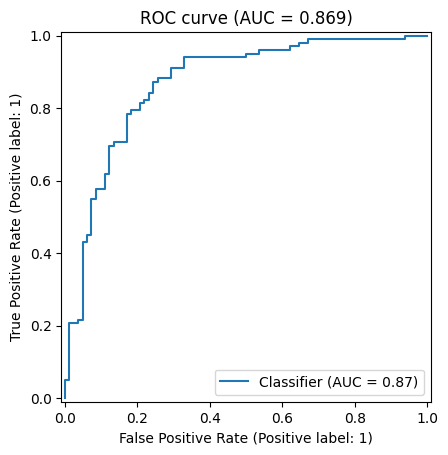

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title(f"ROC curve (AUC = {roc_auc_score(y_test, test_proba):.3f})")
plt.show()


Neural Network Calibration Curve and Predicted Probabilities

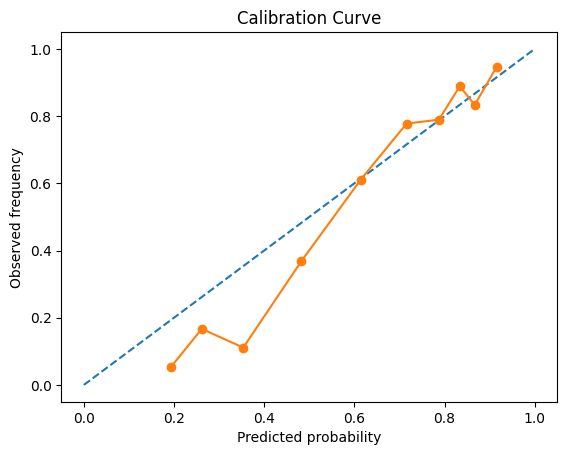

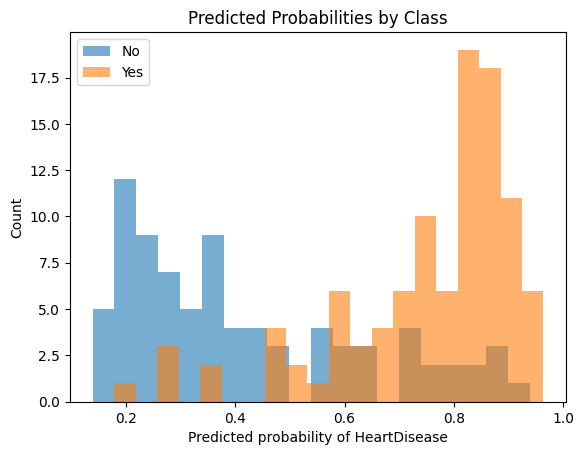

In [32]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10, strategy="quantile")

plt.plot([0,1], [0,1], linestyle="--")
plt.plot(prob_pred, prob_true, marker="o")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.show()

# Bonus: probability histograms by class
plt.hist(test_proba[y_test==0], bins=20, alpha=0.6, label="No")
plt.hist(test_proba[y_test==1], bins=20, alpha=0.6, label="Yes")
plt.xlabel("Predicted probability of HeartDisease")
plt.ylabel("Count")
plt.title("Predicted Probabilities by Class")
plt.legend()
plt.show()

# **Logistic Regression**

In [44]:
# Optional feature engineering that slightly improved classification

def add_engineered_features(df):
    df = df.copy()

    # Transform skewed variables
    df['Cholesterol_log'] = np.log1p(df['Cholesterol'])
    # df['Oldpeak_log'] = np.log1p(df['Oldpeak'] + abs(df['Oldpeak'].min()) + 1)  # handle negatives if any

    # Interaction terms
    df['Age_Cholesterol'] = df['Age'] * df['Cholesterol']
    df['Age_MaxHR'] = df['Age'] * df['MaxHR']
    df['BP_Cholesterol'] = df['RestingBP'] * df['Cholesterol']

    # Polynomial terms
    # df['Age_sq'] = df['Age'] ** 2
    # df['Oldpeak_sq'] = df['Oldpeak'] ** 2

    # Ratios
    # df['Chol_MaxHR_ratio'] = df['Cholesterol'] / (df['MaxHR'] + 1e-5)
    # df['BP_Age_ratio'] = df['RestingBP'] / (df['Age'] + 1e-5)

    # Clinical flags
    df['HighCholFlag'] = (df['Cholesterol'] > 240).astype(int)
    df['HighBPFlag'] = (df['RestingBP'] >= 140).astype(int)

    return df

In [45]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 10000)
result = model.fit(X_train, y_train)

In [46]:
from sklearn import metrics

prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.8926746166950597


In [47]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.7989130434782609


In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction))

[[56 26]
 [11 91]]


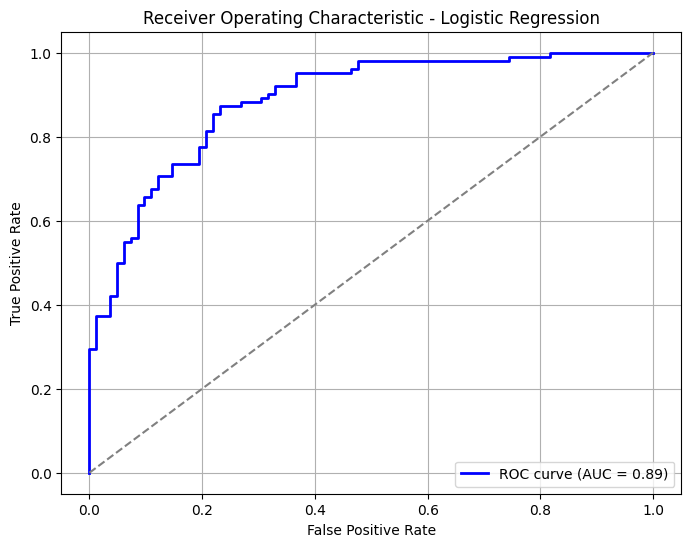

In [49]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [50]:
print(roc_auc)

0.8870157819225251
